<a href="https://colab.research.google.com/github/soopark0221/EN_sentiment_analysis/blob/main/Friends_bert_psy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

In [3]:
!pip install transformers --quiet

In [4]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertModel, BertTokenizer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import sklearn.metrics

In [5]:
traindir = '/content/drive/MyDrive/BERT/friends_train.json' 
devdir = '/content/drive/MyDrive/BERT/friends_dev.json' 
train_data = json.load(open(traindir))
dev_data = json.load(open(devdir))

print('Train Set : {}, Validation Set: {}'.format(len(train_data), len(dev_data)))

Train Set : 720, Validation Set: 80


Transform to Dataframe

In [6]:
train_d = pd.DataFrame.from_dict(train_data[0], orient = 'columns')
dev_d = pd.DataFrame.from_dict(dev_data[0],orient= 'columns')

for i in range(1, len(train_data)):
  train_d = train_d.append(train_data[i], ignore_index= True)
for i in range(1, len(dev_data)):
  dev_d = dev_d.append(dev_data[i], ignore_index= True)

Check class labels

(10561, 4)
neutral        4752
non-neutral    2017
joy            1283
surprise       1220
anger           513
sadness         351
disgust         240
fear            185
Name: emotion, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


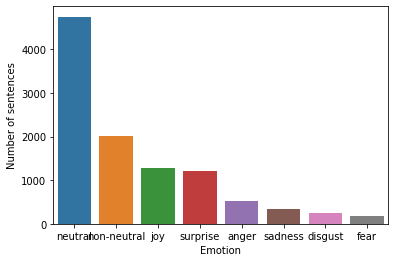

In [7]:
count = train_d['emotion'].value_counts()
print(train_d.shape)
print(count)

x = np.array(count.index)
y = np.array(count.values)
sns.barplot(x,y)
plt.xlabel('Emotion')
new = plt.ylabel('Number of sentences')

Check sentence length 

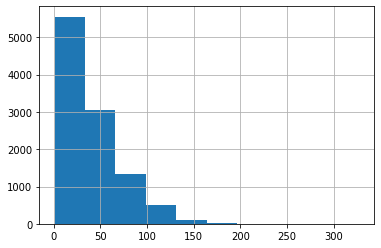

count    10561.000000
mean        39.684784
std         31.925920
min          1.000000
25%         15.000000
50%         32.000000
75%         57.000000
max        327.000000
dtype: float64

In [8]:
review_len = [len(str(doc)) for doc in train_d.utterance]

pd.Series(review_len).hist()
plt.show()
pd.Series(review_len).describe()

# Preprocessing

Label class into Integer

In [9]:
e2i = {'neutral': 0,'non-neutral':1, 'joy':2, 'surprise':3, 'anger':4, 'sadness':5, 'disgust':6, 'fear' : 7} 
train_d['emotion_id'] = [e2i[item] for item in train_d.emotion] 
dev_d['emotion_id'] = [e2i[item] for item in dev_d.emotion] 

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
x_train = [str(utter) for utter in train_d.utterance]
x_dev = [str(utter) for utter in dev_d.utterance]
y_train = train_d.emotion_id.values
y_dev = dev_d.emotion_id.values

Tokenize

In [11]:
def Convert_to_id(data):
  ids = []
  masks = []
  for sent in data:
    encoded = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True,
        padding = 'max_length',
        truncation = True,
        max_length = 40,
        return_attention_mask = True,
    )
    ids.append(encoded['input_ids'])
    masks.append(encoded['attention_mask'])
    
  return ids, masks


Use GPU

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Dataloader

In [13]:
def Get_dataloader(x, y, batchsize):
  x_tensor = torch.tensor(Convert_to_id(x)[0])
  a_tensor = torch.tensor(Convert_to_id(x)[1])
  y_tensor = torch.tensor(y, dtype = torch.long)
  my_dataset = TensorDataset(x_tensor.to(device), y_tensor.to(device), a_tensor.to(device))
  my_dataloader = DataLoader(my_dataset, batch_size = batchsize, sampler = RandomSampler(my_dataset))
  return my_dataloader

In [14]:
import time

batchsize = 16
start_time = time.time()
train_dataloader = Get_dataloader(x_train, y_train, batchsize)
dev_dataloader = Get_dataloader(x_dev, y_dev, batchsize)
print("--- %s seconds ---" % (time.time() - start_time))

--- 11.07674503326416 seconds ---


#Imbalance 

Oversampling

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
x_resample, y_resample = oversample.fit_resample(Convert_to_id(x_train)[0], y_train)
a_resample = []
for seq in x_resample:
    mask = [int(i>0) for i in seq]
    a_resample.append(mask)

s = pd.Series(y_resample)
s.value_counts()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

7    4752
6    4752
5    4752
4    4752
3    4752
2    4752
1    4752
0    4752
dtype: int64

In [ ]:
x_tensor = torch.tensor(x_resample)
a_tensor = torch.tensor(a_resample)
y_tensor = torch.tensor(y_resample, dtype=torch.long)

batchsize = 32
train_dataset = TensorDataset(x_tensor.cuda(),y_tensor.cuda(), a_tensor.cuda())
train_dataloader = DataLoader(train_dataset, batch_size = 32, sampler = RandomSampler(train_dataset))
test_dataloader = Get_dataloader(x_test, y_test, batchsize)
dev_dataloader = Get_dataloader(x_dev, y_dev, batchsize)

Weighted cross entropy

In [ ]:
weights = torch.cuda.FloatTensor([0.278, 0.654, 1.029, 1.082, 2.573, 3.761, 5.501, 7.136])

# Modeling

In [15]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
import torch.nn.functional as F

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.bert_model = BertModel.from_pretrained('bert-base-uncased')
    self.linear = torch.nn.Linear(768,8)
    #self.drop = torch.nn.Dropout(p=0.5)

  def forward(self, input_tensor, attention_masks):
    pooler = self.bert_model(input_tensor, attention_masks)[1]
    t= self.linear(pooler)
    return t

#Training

In [16]:
model = Model()
model.cuda()

Model(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [17]:
from torch.optim.lr_scheduler import StepLR

lr = 0.00001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr) 
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)
epochs = 4
criterion = torch.nn.CrossEntropyLoss() 

In [18]:
for epoch in range(epochs):
  train_loss = 0
  for x,y,a in train_dataloader:
    model.train()
    out = model(x,a)
    loss = criterion(out, y)
    loss.backward() #backprop. gradient calc
    optimizer.step() #update w
    optimizer.zero_grad() #reset gradient
    train_loss += loss.item()
  avg_train_loss = train_loss/len(train_data)
  print('epoch : {}'.format(epoch+1))
  print('avg train loss : {}'.format(avg_train_loss))
  scheduler.step()
  print('LR:', scheduler.get_last_lr())

  correct, total, test_loss = 0, 0, 0
  pred = []
  true = []
  for x_t,y_t,a_t in dev_dataloader:
    model.eval()
    with torch.no_grad():
      testout = model(x_t,a_t)
      testloss = criterion(testout, y_t)
      _,predicted = torch.max(testout,dim=1) #torch.max returns (value, index)
      pred += predicted.tolist()
      true += y_t.tolist()
      total += y_t.size(0) 
      correct += (predicted == y_t).sum().item()
      test_loss += testloss.item()
  accuracy = correct/total #for multi-class, mirco-f1/recall/precision are equal to accuracy
  avg_test_loss = test_loss/len(dev_data)
  print('avg test loss : {}'.format(avg_test_loss))
  print('accuracy: {}'.format(accuracy))
  print('----------------------------------------')

epoch : 1
avg train loss : 1.1714758987848957
LR: [5e-06]
avg test loss : 1.1404951103031635
accuracy: 0.5730050933786078
----------------------------------------
epoch : 2
avg train loss : 0.9421323901042342
LR: [2.5e-06]
avg test loss : 1.0967404536902905
accuracy: 0.5967741935483871
----------------------------------------
epoch : 3
avg train loss : 0.8515761437515418
LR: [1.25e-06]
avg test loss : 1.09718767888844
accuracy: 0.5942275042444821
----------------------------------------
epoch : 4
avg train loss : 0.7903692007685701
LR: [6.25e-07]
avg test loss : 1.101237851381302
accuracy: 0.597623089983022
----------------------------------------


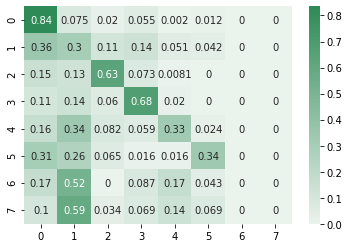

In [19]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(true, pred, labels=[0,1,2,3,4,5,6,7])
matrix_norm = matrix.astype('float')/matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(matrix_norm, cmap=sns.light_palette("seagreen", as_cmap=True), annot=True)

#Test

In [21]:
test = pd.read_csv('/content/drive/MyDrive/BERT/en_data.csv')
x_test = [utter for utter in test.utterance]

In [22]:
pred_list = []
i2e = ['neutral', 'non-neutral','joy','surprise','anger', 'sadness','disgust','fear']

for idx, utter in enumerate(x_test):
  encoded = tokenizer.encode_plus(
        text = utter,
        add_special_tokens = True,
        padding = 'max_length',
        truncation = True,
        max_length = 60,
        return_attention_mask = True,
        return_tensors = 'pt'    
    )
  id = encoded['input_ids'].to(device)
  mask = encoded['attention_mask'].to(device)
  output = model(id, mask)
  _, predicted = torch.max(output, dim=1)

  pred_list.append(i2e[predicted])

In [23]:
pred = pd.DataFrame(pred_list, columns=['Predicted'])
pred.to_csv('/content/drive/MyDrive/BERT/sample.csv')

Model Save

In [24]:
model_path = '/content/drive/MyDrive/BERT/friends_weights.pt'
torch.save(model.state_dict(),model_path)

Model Load

In [25]:
model = Model()
model.load_state_dict(torch.load(model_path))
model.eval()

Model(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
